In [1]:
import os
import torch
import torchvision
from torch.utils.data import random_split
from torchvision import datasets
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )

In [4]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [6]:
def show_example(img, label):
    print('Label: ', trainset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  frog (6)


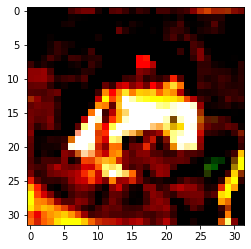

In [7]:
show_example(*trainset[0])

Label:  automobile (1)


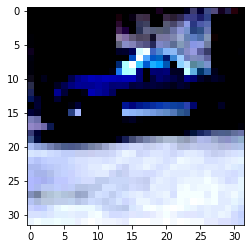

In [8]:
show_example(*trainset[10000])

# Training and Validation Datasets

In [9]:
random_seed = 239
torch.manual_seed(random_seed);

In [10]:
val_size = 5000
train_size = len(trainset) - val_size

train_ds, val_ds = random_split(trainset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [11]:
from torch.utils.data.dataloader import DataLoader

batch_size=128

In [12]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, pin_memory=True)

In [13]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

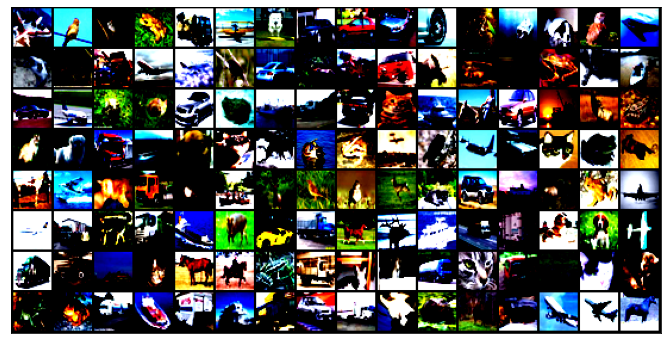

In [14]:
show_batch(train_dl)

# Building the CNN Model

In [15]:
import torch.nn as nn
import torch.nn.functional as F

In [16]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)
        return loss, acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_acc: {:.4f}, val_acc: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}".format(
            epoch, result['train_acc'], result['val_acc'], result['train_loss'], result['val_loss']))
        
def accuracy(outputs, labels):
    preds = torch.argmax(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [17]:
class CNN_base(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 32 x 16 x 16

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 8 x 8

            nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 96 x 4 x 4

            nn.Flatten(), 
            nn.Linear(96*4*4, 64),
            nn.ReLU(),
            nn.Linear(64, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [18]:
model = CNN_base()
model

CNN_base(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1536, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=10, bias=True)
  )
)

# Integrating with GPU

In [19]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [20]:
device = get_default_device()
device

device(type='cuda')

In [21]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

# Training the Model

In [22]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        train_accs = []
        for batch in train_loader:
            loss, acc = model.training_step(batch)
            train_losses.append(loss)
            train_accs.append(acc)
            
            # Compute gradients
            loss.backward()

            # Update parameters
            optimizer.step()

            # Reset gradients
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accs).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [23]:
from torchsummary import summary

In [24]:
model = to_device(CNN_base(), device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 96, 8, 8]          55,392
              ReLU-8             [-1, 96, 8, 8]               0
         MaxPool2d-9             [-1, 96, 4, 4]               0
          Flatten-10                 [-1, 1536]               0
           Linear-11                   [-1, 64]          98,368
             ReLU-12                   [-1, 64]               0
           Linear-13                   [-1, 10]             650
Total params: 173,802
Trainable params:

In [ ]:
evaluate(model, val_dl)

{'val_loss': 2.30602765083313, 'val_acc': 0.1053883284330368}

# Experiments on the Baseline

# Varying learning rate

In [ ]:
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
%%time
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_acc: 0.4558, val_acc: 0.5649, train_loss: 1.5036, val_loss: 1.1985
Epoch [1], train_acc: 0.6150, val_acc: 0.6424, train_loss: 1.0860, val_loss: 1.0274
Epoch [2], train_acc: 0.6805, val_acc: 0.6678, train_loss: 0.9061, val_loss: 0.9349
Epoch [3], train_acc: 0.7178, val_acc: 0.7021, train_loss: 0.8027, val_loss: 0.8522
Epoch [4], train_acc: 0.7495, val_acc: 0.7210, train_loss: 0.7149, val_loss: 0.7995
Epoch [5], train_acc: 0.7772, val_acc: 0.7285, train_loss: 0.6422, val_loss: 0.7792
Epoch [6], train_acc: 0.7972, val_acc: 0.7330, train_loss: 0.5810, val_loss: 0.7740
Epoch [7], train_acc: 0.8158, val_acc: 0.7400, train_loss: 0.5250, val_loss: 0.7698
Epoch [8], train_acc: 0.8314, val_acc: 0.7334, train_loss: 0.4802, val_loss: 0.8161
Epoch [9], train_acc: 0.8483, val_acc: 0.7449, train_loss: 0.4299, val_loss: 0.7889
Epoch [10], train_acc: 0.8659, val_acc: 0.7310, train_loss: 0.3821, val_loss: 0.8801
Epoch [11], train_acc: 0.8792, val_acc: 0.7295, train_loss: 0.3426, val_los

In [25]:
def plot_accuracies(history):
    train_accuracies = [x['train_acc'] for x in history]
    val_accuracies = [x['val_acc'] for x in history]
    plt.plot(train_accuracies, '-bx')
    plt.plot(val_accuracies, '-rx')    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');

In [26]:
def plot_losses(history):
    train_losses = [x['train_loss'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
evaluate(model, val_dl)

{'val_loss': 1.0142477750778198, 'val_acc': 0.7426010966300964}

In [ ]:
base2 = to_device(CNN_base(), device)
summary(base2, (3, 32, 32))

num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.01

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 96, 8, 8]          55,392
              ReLU-8             [-1, 96, 8, 8]               0
         MaxPool2d-9             [-1, 96, 4, 4]               0
          Flatten-10                 [-1, 1536]               0
           Linear-11                   [-1, 64]          98,368
             ReLU-12                   [-1, 64]               0
           Linear-13                   [-1, 10]             650
Total params: 173,802
Trainable params:

In [ ]:
%%time
history_base2 = fit(num_epochs, lr, base2, train_dl, val_dl, opt_func)

Epoch [0], train_acc: 0.0991, val_acc: 0.0937, train_loss: 2.3497, val_loss: 2.3034
Epoch [1], train_acc: 0.0989, val_acc: 0.1043, train_loss: 2.3034, val_loss: 2.3031
Epoch [2], train_acc: 0.0976, val_acc: 0.0937, train_loss: 2.3034, val_loss: 2.3030
Epoch [3], train_acc: 0.1001, val_acc: 0.0982, train_loss: 2.3033, val_loss: 2.3041
Epoch [4], train_acc: 0.1005, val_acc: 0.0982, train_loss: 2.3032, val_loss: 2.3035
Epoch [5], train_acc: 0.1002, val_acc: 0.1043, train_loss: 2.3033, val_loss: 2.3027
Epoch [6], train_acc: 0.0990, val_acc: 0.0937, train_loss: 2.3033, val_loss: 2.3040
Epoch [7], train_acc: 0.0963, val_acc: 0.1002, train_loss: 2.3034, val_loss: 2.3036
Epoch [8], train_acc: 0.0991, val_acc: 0.0937, train_loss: 2.3034, val_loss: 2.3033
Epoch [9], train_acc: 0.1015, val_acc: 0.1001, train_loss: 2.3032, val_loss: 2.3039
Epoch [10], train_acc: 0.0974, val_acc: 0.1043, train_loss: 2.3036, val_loss: 2.3026
Epoch [11], train_acc: 0.0982, val_acc: 0.1043, train_loss: 2.3034, val_los

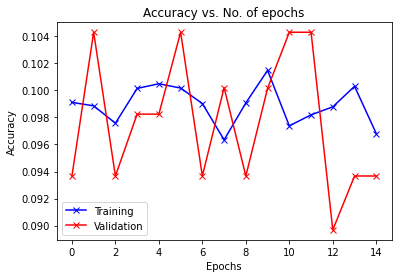

In [ ]:
plot_accuracies(history_base2)

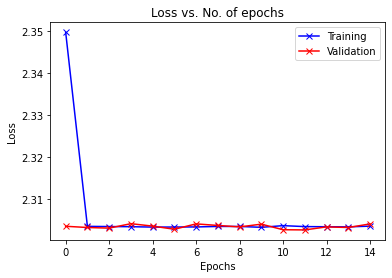

In [ ]:
plot_losses(history_base2)

In [ ]:
evaluate(base2, val_dl)

{'val_loss': 2.3039913177490234, 'val_acc': 0.0936695784330368}

In [ ]:
base3 = to_device(CNN_base(), device)
summary(base3, (3, 32, 32))

num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.0001

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 96, 8, 8]          55,392
              ReLU-8             [-1, 96, 8, 8]               0
         MaxPool2d-9             [-1, 96, 4, 4]               0
          Flatten-10                 [-1, 1536]               0
           Linear-11                   [-1, 64]          98,368
             ReLU-12                   [-1, 64]               0
           Linear-13                   [-1, 10]             650
Total params: 173,802
Trainable params:

In [ ]:
%%time
history_base3 = fit(num_epochs, lr, base3, train_dl, val_dl, opt_func)

Epoch [0], train_acc: 0.3208, val_acc: 0.4278, train_loss: 1.8905, val_loss: 1.6177
Epoch [1], train_acc: 0.4452, val_acc: 0.4857, train_loss: 1.5374, val_loss: 1.4415
Epoch [2], train_acc: 0.4990, val_acc: 0.5164, train_loss: 1.4078, val_loss: 1.3552
Epoch [3], train_acc: 0.5282, val_acc: 0.5466, train_loss: 1.3318, val_loss: 1.2851
Epoch [4], train_acc: 0.5545, val_acc: 0.5685, train_loss: 1.2659, val_loss: 1.2323
Epoch [5], train_acc: 0.5681, val_acc: 0.5652, train_loss: 1.2232, val_loss: 1.2202
Epoch [6], train_acc: 0.5861, val_acc: 0.5935, train_loss: 1.1823, val_loss: 1.1576
Epoch [7], train_acc: 0.6015, val_acc: 0.6016, train_loss: 1.1402, val_loss: 1.1516
Epoch [8], train_acc: 0.6138, val_acc: 0.6136, train_loss: 1.1058, val_loss: 1.1045
Epoch [9], train_acc: 0.6254, val_acc: 0.6225, train_loss: 1.0780, val_loss: 1.0654
Epoch [10], train_acc: 0.6352, val_acc: 0.6376, train_loss: 1.0531, val_loss: 1.0504
Epoch [11], train_acc: 0.6433, val_acc: 0.6388, train_loss: 1.0267, val_los

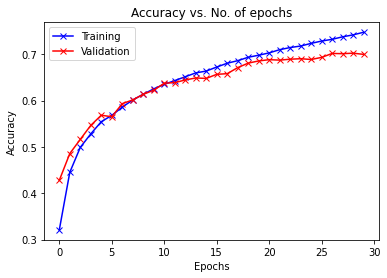

In [ ]:
plot_accuracies(history_base3)

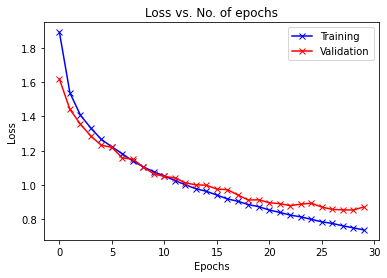

In [ ]:
plot_losses(history_base3)

In [ ]:
evaluate(base3, val_dl)

{'val_loss': 0.872700035572052, 'val_acc': 0.6998850703239441}

## With Batchnorm

In [27]:
class CNN_batchnorm(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 8 x 8

            nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 96 x 4 x 4

            nn.Flatten(), 
            nn.Linear(96*4*4, 64),
            nn.ReLU(),
            nn.Linear(64, 10))
       
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model2 = to_device(CNN_batchnorm(), device)
summary(model2, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 96, 8, 8]          55,392
      BatchNorm2d-10             [-1, 96, 8, 8]             192
             ReLU-11             [-1, 96, 8, 8]               0
        MaxPool2d-12             [-1, 96, 4, 4]               0
          Flatten-13                 [-1, 1536]               0
           Linear-14                   

In [ ]:
%%time
history2 = fit(num_epochs, lr, model2, train_dl, val_dl, opt_func)

Epoch [0], train_acc: 0.5596, val_acc: 0.6188, train_loss: 1.2299, val_loss: 1.0622
Epoch [1], train_acc: 0.7024, val_acc: 0.7096, train_loss: 0.8563, val_loss: 0.8126
Epoch [2], train_acc: 0.7413, val_acc: 0.7163, train_loss: 0.7421, val_loss: 0.8151
Epoch [3], train_acc: 0.7740, val_acc: 0.7371, train_loss: 0.6533, val_loss: 0.7639
Epoch [4], train_acc: 0.7982, val_acc: 0.7626, train_loss: 0.5777, val_loss: 0.6825
Epoch [5], train_acc: 0.8183, val_acc: 0.7628, train_loss: 0.5181, val_loss: 0.6822
Epoch [6], train_acc: 0.8386, val_acc: 0.7484, train_loss: 0.4644, val_loss: 0.7596
Epoch [7], train_acc: 0.8551, val_acc: 0.7424, train_loss: 0.4130, val_loss: 0.8065
Epoch [8], train_acc: 0.8716, val_acc: 0.7616, train_loss: 0.3653, val_loss: 0.7426
Epoch [9], train_acc: 0.8888, val_acc: 0.7726, train_loss: 0.3188, val_loss: 0.7199
Epoch [10], train_acc: 0.8988, val_acc: 0.7725, train_loss: 0.2869, val_loss: 0.7604
Epoch [11], train_acc: 0.9155, val_acc: 0.7371, train_loss: 0.2474, val_los

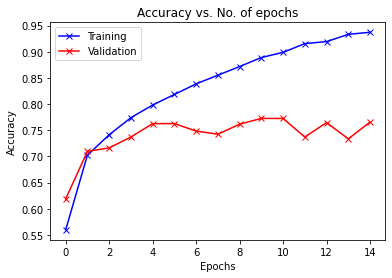

In [ ]:
plot_accuracies(history2)

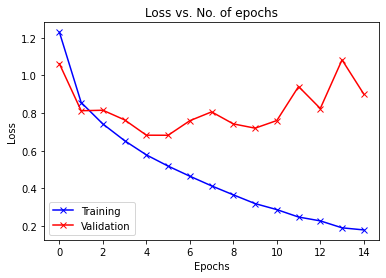

In [ ]:
plot_losses(history2)

## With dropout

In [28]:
class CNN_batchnorm_dropout(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 8 x 8

            nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 96 x 4 x 4

            nn.Flatten(), 
            nn.Linear(96*4*4, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 10))

    def forward(self, xb):
        return self.network(xb)


In [29]:
model3 = to_device(CNN_batchnorm_dropout(), device)
summary(model3, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 96, 8, 8]          55,392
      BatchNorm2d-10             [-1, 96, 8, 8]             192
             ReLU-11             [-1, 96, 8, 8]               0
        MaxPool2d-12             [-1, 96, 4, 4]               0
          Flatten-13                 [-1, 1536]               0
           Linear-14                   

In [ ]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
%%time
history3 = fit(num_epochs, lr, model3, train_dl, val_dl, opt_func)

Epoch [0], train_acc: 0.5100, val_acc: 0.6299, train_loss: 1.3538, val_loss: 1.0538
Epoch [1], train_acc: 0.6498, val_acc: 0.6792, train_loss: 0.9888, val_loss: 0.9145
Epoch [2], train_acc: 0.7005, val_acc: 0.6961, train_loss: 0.8597, val_loss: 0.8457
Epoch [3], train_acc: 0.7255, val_acc: 0.7364, train_loss: 0.7795, val_loss: 0.7364
Epoch [4], train_acc: 0.7503, val_acc: 0.7205, train_loss: 0.7118, val_loss: 0.7994
Epoch [5], train_acc: 0.7662, val_acc: 0.7459, train_loss: 0.6663, val_loss: 0.7229
Epoch [6], train_acc: 0.7905, val_acc: 0.7540, train_loss: 0.6022, val_loss: 0.7209
Epoch [7], train_acc: 0.8017, val_acc: 0.7506, train_loss: 0.5684, val_loss: 0.7080
Epoch [8], train_acc: 0.8151, val_acc: 0.7793, train_loss: 0.5231, val_loss: 0.6545
Epoch [9], train_acc: 0.8285, val_acc: 0.7825, train_loss: 0.4859, val_loss: 0.6401
Epoch [10], train_acc: 0.8388, val_acc: 0.7708, train_loss: 0.4568, val_loss: 0.6741
Epoch [11], train_acc: 0.8498, val_acc: 0.7809, train_loss: 0.4280, val_los

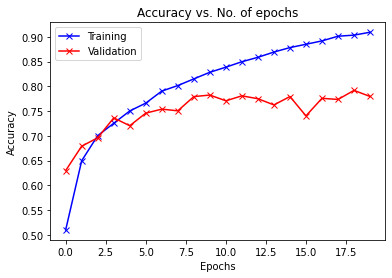

In [ ]:
plot_accuracies(history3)

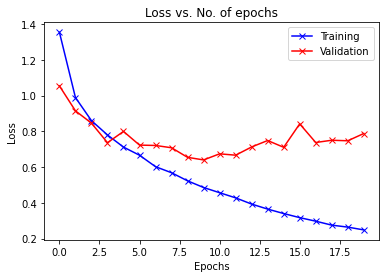

In [ ]:
plot_losses(history3)

In [ ]:
class CNN_dropout(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 8 x 8

            nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 96 x 4 x 4

            nn.Flatten(), 
            nn.Linear(96*4*4, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 10))

    def forward(self, xb):
        return self.network(xb)


# Data Transformation + Augmentation

In [ ]:
import torchvision.transforms as tt

# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stats,inplace=True)])
test_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [ ]:
trainset_t = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_tfms)
testset_t = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_tfms)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
trainset_t

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )

In [ ]:
# PyTorch datasets
# train_trans = ImageFolder(data_dir+'/train', transform = train_tfms)
# test_trans = ImageFolder(data_dir+'/test', test_tfms)

In [ ]:
val_size = 5000
train_size = len(trainset_t) - val_size

train_ds_t, val_ds_t = random_split(trainset_t, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [ ]:
batch_size = 400

# PyTorch data loaders
train_dl_t = DataLoader(train_ds_t, batch_size, shuffle=True, pin_memory=True)
val_dl_t = DataLoader(val_ds_t, batch_size*2, pin_memory=True)
test_dl_t = DataLoader(testset_t, batch_size*2, pin_memory=True)

train_dl_t = DeviceDataLoader(train_dl_t, device)
val_dl_t = DeviceDataLoader(val_dl_t, device)

In [ ]:
model4 = to_device(CNN_batchnorm_dropout(), device)
summary(model4, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 96, 8, 8]          55,392
      BatchNorm2d-10             [-1, 96, 8, 8]             192
             ReLU-11             [-1, 96, 8, 8]               0
        MaxPool2d-12             [-1, 96, 4, 4]               0
          Flatten-13                 [-1, 1536]               0
           Linear-14                   

In [ ]:
num_epochs = 25
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
%%time
history4 = fit(num_epochs, lr, model4, train_dl_t, val_dl_t, opt_func)

Epoch [0], train_acc: 0.4478, val_acc: 0.5586, train_loss: 1.5036, val_loss: 1.2087
Epoch [1], train_acc: 0.5775, val_acc: 0.6119, train_loss: 1.1783, val_loss: 1.1028
Epoch [2], train_acc: 0.6289, val_acc: 0.6487, train_loss: 1.0446, val_loss: 0.9795
Epoch [3], train_acc: 0.6555, val_acc: 0.7018, train_loss: 0.9720, val_loss: 0.8526
Epoch [4], train_acc: 0.6819, val_acc: 0.7179, train_loss: 0.9092, val_loss: 0.8192
Epoch [5], train_acc: 0.6887, val_acc: 0.7058, train_loss: 0.8828, val_loss: 0.8440
Epoch [6], train_acc: 0.7037, val_acc: 0.7226, train_loss: 0.8478, val_loss: 0.7929
Epoch [7], train_acc: 0.7134, val_acc: 0.7383, train_loss: 0.8150, val_loss: 0.7508
Epoch [8], train_acc: 0.7200, val_acc: 0.7260, train_loss: 0.7948, val_loss: 0.7919
Epoch [9], train_acc: 0.7313, val_acc: 0.7527, train_loss: 0.7676, val_loss: 0.7141
Epoch [10], train_acc: 0.7382, val_acc: 0.7415, train_loss: 0.7517, val_loss: 0.7508
Epoch [11], train_acc: 0.7437, val_acc: 0.7257, train_loss: 0.7380, val_los

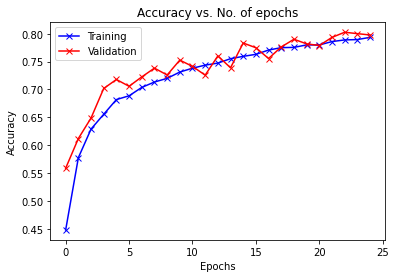

In [ ]:
plot_accuracies(history4)

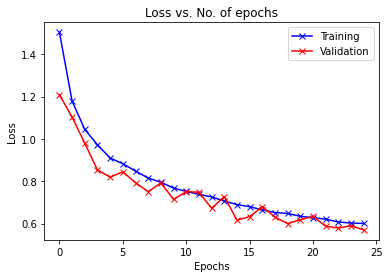

In [ ]:
plot_losses(history4)

# Residual Network

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
resnet9 = to_device(ResNet9(3, 10), device)
summary(resnet9, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
         MaxPool2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

In [ ]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history5 = fit(num_epochs, lr, resnet9, train_dl_t, val_dl_t, opt_func)

Epoch [0], train_acc: 0.4383, val_acc: 0.4818, train_loss: 1.6101, val_loss: 1.4995
Epoch [1], train_acc: 0.6330, val_acc: 0.6662, train_loss: 1.0400, val_loss: 0.9749
Epoch [2], train_acc: 0.7189, val_acc: 0.6834, train_loss: 0.8034, val_loss: 0.9727
Epoch [3], train_acc: 0.7688, val_acc: 0.7889, train_loss: 0.6639, val_loss: 0.6211
Epoch [4], train_acc: 0.8029, val_acc: 0.7932, train_loss: 0.5747, val_loss: 0.6060
Epoch [5], train_acc: 0.8258, val_acc: 0.7948, train_loss: 0.5064, val_loss: 0.6058
Epoch [6], train_acc: 0.8435, val_acc: 0.8262, train_loss: 0.4536, val_loss: 0.5049
Epoch [7], train_acc: 0.8565, val_acc: 0.8305, train_loss: 0.4132, val_loss: 0.5046
Epoch [8], train_acc: 0.8700, val_acc: 0.8373, train_loss: 0.3806, val_loss: 0.4863
Epoch [9], train_acc: 0.8790, val_acc: 0.8134, train_loss: 0.3483, val_loss: 0.5440
Epoch [10], train_acc: 0.8873, val_acc: 0.8438, train_loss: 0.3240, val_loss: 0.4497
Epoch [11], train_acc: 0.8946, val_acc: 0.8571, train_loss: 0.3062, val_los

In [ ]:
plot_accuracies(history5)

In [ ]:
plot_losses(history5)

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return testset_t.classes[preds[0].item()]

Label: ship , Predicted: ship


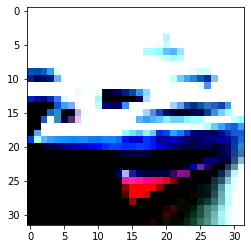

In [ ]:
img, label = testset_t[1]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', testset_t.classes[label], ', Predicted:', predict_image(img, model5))

# Transfer Learning (Using pretrained models with weights)

In [ ]:
%matplotlib inline
from copy import deepcopy
from collections import OrderedDict
import gc
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD,Adam,lr_scheduler
from torch.utils.data import random_split
import torchvision
from torchvision import transforms,models

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    transforms.Normalize(*stats,inplace=True)])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(*stats,inplace=True)])

traindata = torchvision.datasets.CIFAR10(root='.', train=True,download=True, transform=train_transform)
trainset,valset = random_split(traindata,[45000,5000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64,shuffle=False)

testset = torchvision.datasets.CIFAR10(root='.', train=False,download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=False)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [ ]:
trainloader = DeviceDataLoader(trainloader, device)
valloader = DeviceDataLoader(valloader, device)
testloader = DeviceDataLoader(testloader, device)

In [ ]:
resnet9 = to_device(ResNet9(3, 10), device)
summary(resnet9, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
         MaxPool2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

In [ ]:
class ResNet18(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        base = models.resnet18(pretrained=True)
        self.base = nn.Sequential(*list(base.children())[:-1])
        in_features = base.fc.in_features
        self.drop = nn.Dropout()
        self.final = nn.Linear(in_features,10)
    
    def forward(self,x):
        x = self.base(x)
        x = self.drop(x.view(-1,self.final.in_features))
        return self.final(x)

In [ ]:
resnet18 = to_device(ResNet18(), device)
summary(resnet18, (3, 32, 32))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [ ]:
evaluate(resnet18, testloader)

{'val_loss': 0.2548747956752777, 'val_acc': 0.918988823890686}

In [ ]:
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
%%time
history_resnet18 = fit(num_epochs, lr, resnet18, trainloader, valloader, opt_func)

Epoch [0], train_acc: 0.7399, val_acc: 0.7648, train_loss: 0.7629, val_loss: 0.6942
Epoch [1], train_acc: 0.8334, val_acc: 0.8382, train_loss: 0.4928, val_loss: 0.4848
Epoch [2], train_acc: 0.8664, val_acc: 0.8544, train_loss: 0.3947, val_loss: 0.4144
Epoch [3], train_acc: 0.8832, val_acc: 0.8879, train_loss: 0.3435, val_loss: 0.3303
Epoch [4], train_acc: 0.8940, val_acc: 0.8776, train_loss: 0.3094, val_loss: 0.3835
Epoch [5], train_acc: 0.9064, val_acc: 0.8886, train_loss: 0.2732, val_loss: 0.3582
Epoch [6], train_acc: 0.9111, val_acc: 0.8794, train_loss: 0.2568, val_loss: 0.3878
Epoch [7], train_acc: 0.9232, val_acc: 0.9021, train_loss: 0.2276, val_loss: 0.2990
Epoch [8], train_acc: 0.9263, val_acc: 0.8966, train_loss: 0.2135, val_loss: 0.3405
Epoch [9], train_acc: 0.9348, val_acc: 0.9025, train_loss: 0.1908, val_loss: 0.2973
Epoch [10], train_acc: 0.9375, val_acc: 0.9057, train_loss: 0.1817, val_loss: 0.3107
Epoch [11], train_acc: 0.9413, val_acc: 0.9112, train_loss: 0.1724, val_los

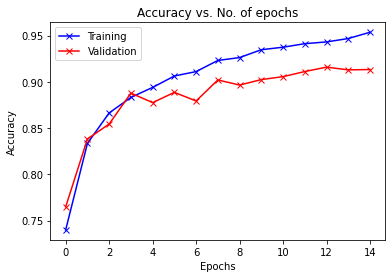

In [ ]:
plot_accuracies(history_resnet18)

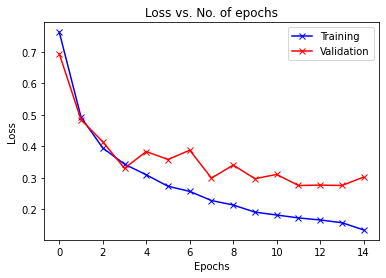

In [ ]:
plot_losses(history_resnet18)

In [ ]:
evaluate(resnet18, testloader)

{'val_loss': 0.2787243723869324, 'val_acc': 0.9207802414894104}

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
dataiter = iter(test_dl_t)
images, labels = next(dataiter)

In [ ]:
evaluate(test)

RuntimeError: ignored

In [ ]:
evaluate(resnet_18, test_dl_t)

AttributeError: ignored

In [ ]:
def accuracy(outputs, labels):
    preds = torch.argmax(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))